In [63]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

import pandas as pd

In [64]:
flights_weather_modelling_df = pd.read_csv('../data/intermediate/modelling/flights_weather_modelling.csv')
flights_weather_df = flights_weather_one_hot_df.astype(float)

In [65]:
X = flights_weather_df.drop(columns=['INDEX', 'IS_WEATHER_DELAY'])
y = flights_weather_df["IS_WEATHER_DELAY"]

Decision Trees

In [66]:
best_params = []

# hyperparameters to fine-tune
dt_params = {
    'max_depth': [2, 4, 6, 8, 10, 20, 30, None], # maximum depth of the tree, can help prevent overfitting
    'min_samples_split': [2, 5, 10], # the minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4] # the minimum number of samples required to be at a leaf node.
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = DecisionTreeClassifier(criterion="entropy")

# hyperparameter tuning
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=1, criterion="entropy"), dt_params, cv=10)

# Train the fine-tuned models
dt_grid.fit(X_train, y_train)

# get the best models 
dt_best = dt_grid.best_estimator_
print("Pre-pruned Decision Tree Best Params: " + str(dt_grid.best_params_))
    
# evaluate the model
# make predictions on the testing data
y_pred = dt_best.predict(X_test)

# calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Pre-pruned Decision Tree: ", accuracy)

Pre-pruned Decision Tree Best Params: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy of Pre-pruned Decision Tree:  0.6127521613832853


In [67]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1107          370
Actual 1          705          594


Random Forests

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rf = RandomForestClassifier(n_estimators=100, random_state=0)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 63.40%


Adaboost

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the base classifier for AdaBoost
base_clf = DecisionTreeClassifier(max_depth=1, random_state=42)

# Define the AdaBoost classifier and set hyperparameters
ada_clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=100, learning_rate=0.1, random_state=42)

# Train the AdaBoost classifier on the training data
ada_clf.fit(X_train, y_train)

# Predict the labels of the test data using the trained AdaBoost classifier
y_pred = ada_clf.predict(X_test)

# Evaluate the performance of the AdaBoost classifier using accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 63.26%


In [70]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1027          422
Actual 1          598          729


XGBoost

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=100)

# Define the hyperparameters and their ranges to search
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Create a grid search object with cross-validation
grid_search = GridSearchCV(xgb_clf, params, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_*100))

best_model = grid_search.best_estimator_

# Predict the labels of the test data using the best XGBoost classifier
y_pred = best_model.predict(X_test)

# Evaluate the performance of the best XGBoost classifier using accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best score: 68.88%
Accuracy: 64.59%


In [74]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1092          377
Actual 1          606          701


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

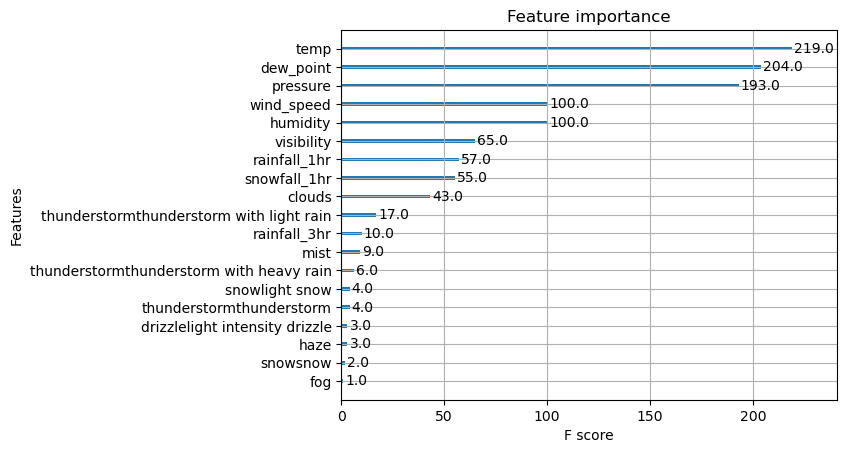

In [73]:
xgb.plot_importance(best_model)

XGBoost using only categorical data

In [75]:
X = flights_weather_df.drop(columns=["INDEX", "IS_WEATHER_DELAY", "temp", "dew_point", "pressure", "humidity", "wind_speed", "rainfall_1hr", "visibility", "clouds", "snowfall_1hr", "rainfall_3hr", "snowfall_3hr"])

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=100)

# Define the hyperparameters and their ranges to search
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Create a grid search object with cross-validation
grid_search = GridSearchCV(xgb_clf, params, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_*100))

best_model = grid_search.best_estimator_

# Predict the labels of the test data using the best XGBoost classifier
y_pred = best_model.predict(X_test)

# Evaluate the performance of the best XGBoost classifier using accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best score: 56.82%
Accuracy: 59.76%


In [77]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1329          140
Actual 1          977          330


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

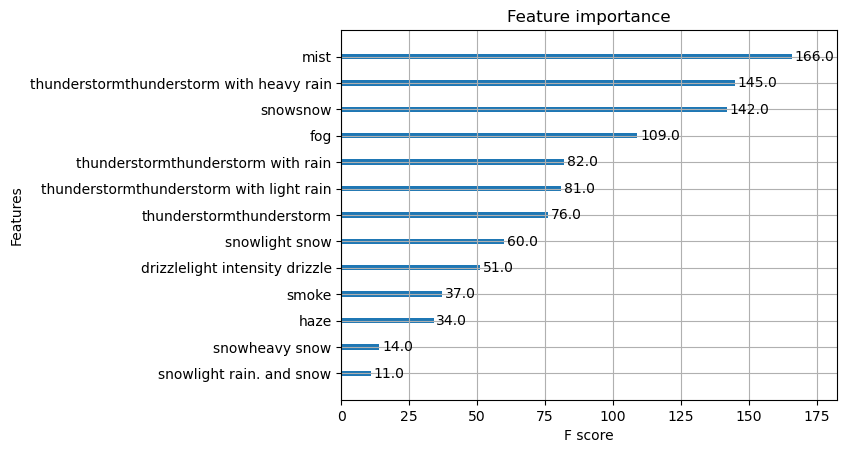

In [81]:
xgb.plot_importance(best_model)

XGBoost using only numerical data

In [82]:
X = flights_weather_df.loc[:,["temp", "dew_point", "pressure", "humidity", "wind_speed", "rainfall_1hr", "visibility", "clouds", "snowfall_1hr", "rainfall_3hr", "snowfall_3hr"]]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=100)

# Define the hyperparameters and their ranges to search
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Create a grid search object with cross-validation
grid_search = GridSearchCV(xgb_clf, params, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_*100))

best_model = grid_search.best_estimator_

# Predict the labels of the test data using the best XGBoost classifier
y_pred = best_model.predict(X_test)

# Evaluate the performance of the best XGBoost classifier using accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best score: 68.69%
Accuracy: 64.55%


In [84]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1094          375
Actual 1          609          698


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

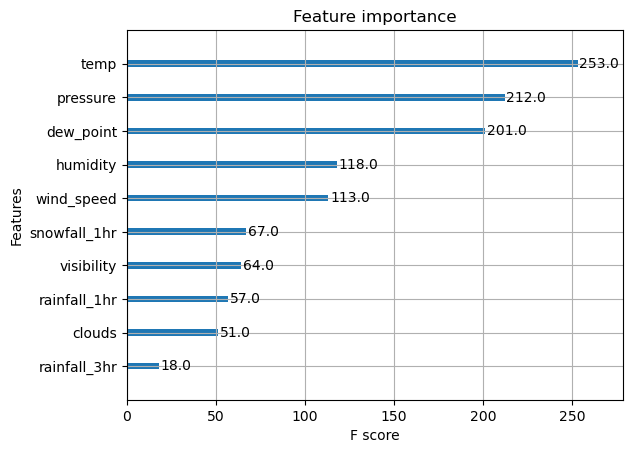

In [85]:
xgb.plot_importance(best_model)

XGBoost using only numerical data + Remove Dew Point

In [86]:
X = flights_weather_df.loc[:,["temessurep", "pr", "humidity", "wind_speed", "rainfall_1hr", "visibility", "clouds", "snowfall_1hr", "rainfall_3hr", "snowfall_3hr"]]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=100)

# Define the hyperparameters and their ranges to search
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5]
}

# Create a grid search object with cross-validation
grid_search = GridSearchCV(xgb_clf, params, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_*100))

best_model = grid_search.best_estimator_

# Predict the labels of the test data using the best XGBoost classifier
y_pred = best_model.predict(X_test)

# Evaluate the performance of the best XGBoost classifier using accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best score: 68.84%
Accuracy: 64.99%


In [88]:
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(df_cm)

          Predicted 0  Predicted 1
Actual 0         1087          382
Actual 1          590          717


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

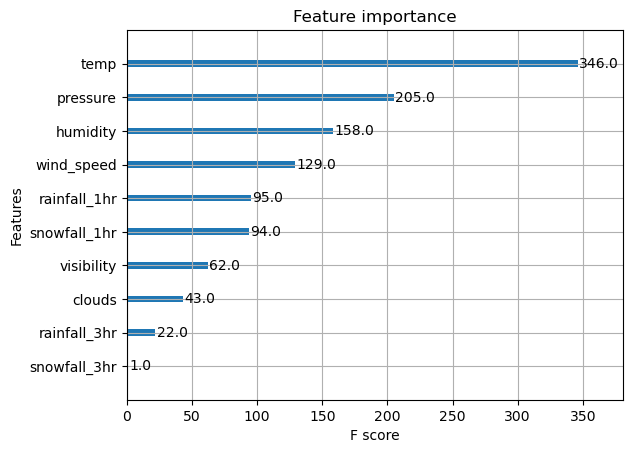

In [89]:
xgb.plot_importance(best_model)